<a href="https://colab.research.google.com/github/1kaiser/Snow-cover-area-estimation/blob/main/MLP_SnowCoverEstimate_Image_training_Parallel_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

new test

test for compatibility

In [1]:
# load DEM file (digital elevation map)
!wget https://github.com/1kaiser/R_e/releases/download/1/x1_Dem.tif

# load rainfall data 2016
!wget https://github.com/1kaiser/R_e/releases/download/1/x1fileout_2016_HourlyRain.zip
!unzip /content/x1fileout_2016_HourlyRain.zip
rain_fplder = f'/content/rain'
!mkdir -p {rain_fplder}
!mv /content/*.txt {rain_fplder}

# load soil map  data 2016
!wget https://github.com/1kaiser/R_e/releases/download/1/x12016_soil_m.zip
!unzip /content/x12016_soil_m.zip

# load catchment/watershed shape file
!wget https://github.com/1kaiser/R_e/releases/download/1/x1boundaryOutputx.zip
!unzip /content/x1boundaryOutputx.zip

Streaming output truncated to the last 5000 lines.
  inflating: fileout_2016_10_08_08.txt  
  inflating: fileout_2016_10_08_09.txt  
  inflating: fileout_2016_10_08_10.txt  
  inflating: fileout_2016_10_08_11.txt  
  inflating: fileout_2016_10_08_12.txt  
  inflating: fileout_2016_10_08_13.txt  
  inflating: fileout_2016_10_08_14.txt  
  inflating: fileout_2016_10_08_15.txt  
  inflating: fileout_2016_10_08_16.txt  
  inflating: fileout_2016_10_08_17.txt  
  inflating: fileout_2016_10_08_18.txt  
  inflating: fileout_2016_10_08_19.txt  
  inflating: fileout_2016_10_08_20.txt  
  inflating: fileout_2016_10_08_21.txt  
  inflating: fileout_2016_10_08_22.txt  
  inflating: fileout_2016_10_08_23.txt  
  inflating: fileout_2016_10_09_00.txt  
  inflating: fileout_2016_10_09_01.txt  
  inflating: fileout_2016_10_09_02.txt  
  inflating: fileout_2016_10_09_03.txt  
  inflating: fileout_2016_10_09_04.txt  
  inflating: fileout_2016_10_09_05.txt  
  inflating: fileout_2016_10_09_06.txt  
  infl

In [2]:
# installing gdal binary
!sudo apt-get install gdal-bin

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-gdal python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 19 not upgraded.
Need to get 4,968 kB of archives.
After this operation, 24.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-numpy amd64 1:1.21.5-1ubuntu22.04.1 [3,467 kB]
Get:2 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 python3-gdal amd64 3.4.3+dfsg-1~jammy0 [967 kB]
Get:3 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 gdal-bin amd64 3.4.3+dfsg-1~jammy0 [534 kB]
Fetched 4,968 kB in 4s (1,372 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, 

In [3]:
import os
import numpy as np
from osgeo import gdal, osr
from scipy.interpolate import griddata
import multiprocessing

# Specify the folder containing the data files
folder_path_txt = '/content/rain'  # Update this to the actual folder path
out_folder_path = '/content/rain_raster'
shapefile = '/content/boundaryOutputx.shp'  # Update this to the actual shapefile path

# Function to process a single data file
def process_data_file(args):
    input_filename, resolution = args  # Unpack the tuple

    # Step 1: Read data from the text file without skipping any rows
    data = np.genfromtxt(input_filename, delimiter=',', dtype=float)

    # Extract columns from the data
    latitudes = data[:, 0]
    longitudes = data[:, 1]
    rainfall = data[:, 6]

    # Step 2: Calculate the number of columns and rows based on latitude and longitude extent
    min_lat, max_lat = min(latitudes), max(latitudes)
    min_lon, max_lon = min(longitudes), max(longitudes)
    num_columns = int((max_lon - min_lon) / resolution) + 1
    num_rows = int((max_lat - min_lat) / resolution) + 1

    # Step 3: Interpolate the rainfall values onto the grid
    grid_x, grid_y = np.meshgrid(np.linspace(min_lon, max_lon, num_columns), np.linspace(min_lat, max_lat, num_rows))
    grid_z = griddata((longitudes, latitudes), rainfall, (grid_x, grid_y), method='cubic', fill_value=0)

    # Step 4: Create a GeoTIFF raster using GDAL
    driver = gdal.GetDriverByName('GTiff')
    output_filename = os.path.join(folder_path_txt, f'{os.path.basename(input_filename)[:-4]}.tif')  # Same name as the original file
    output_raster = driver.Create(output_filename, num_columns, num_rows, 1, gdal.GDT_Float32)
    geotransform = (min_lon, resolution, 0, max_lat, 0, -resolution)
    output_raster.SetGeoTransform(geotransform)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)
    output_raster.SetProjection(srs.ExportToWkt())
    output_band = output_raster.GetRasterBand(1)
    output_band.WriteArray(grid_z)
    output_band.FlushCache()

    output_raster = None  # Close the output raster file

    # Step 5: Clip the rainfall raster using the shapefile
    clip_output_raster = os.path.join(out_folder_path, f'{os.path.basename(input_filename)[:-4]}.tif')
    temp_filename = os.path.join(out_folder_path, f't_{os.path.basename(input_filename)[:-4]}.tif')
        # Open the TIFF file
    !gdalwarp -tr 0.001 0.001 -overwrite {output_filename} {temp_filename}
    !gdalwarp -cutline {shapefile} -dstnodata 0 -overwrite {temp_filename} {clip_output_raster}
    !rm -rf {temp_filename}

# Function to process data files in parallel
def process_data_files_in_parallel(files, resolution=0.001):
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())  # Use all available CPU cores
    # Update the way arguments are passed to the process_data_file function
    pool.map(process_data_file, [(file, resolution) for file in files])
    pool.close()
    pool.join()

# Get a list of all text files in the folder
data_files = [os.path.join(folder_path_txt, filename) for filename in os.listdir(folder_path_txt) if filename.endswith(".txt")]


!mkdir -p /content/rain_raster

In [ ]:
!rm -rf /content/rain_raster/*

In [4]:
# Call the function to process data files in parallel with adjustable resolution
process_data_files_in_parallel(data_files[:20], resolution=0.001)  # Adjust the resolution as needed

Creating output file that is 501P x 1001L.
Processing /content/rain/fileout_2016_11_07_04.tif [1/1] : 0...10...20...30...40...50Creating output file that is 501P x 1001L.
Processing /content/rain/fileout_2016_04_19_17.tif [1/1] : 0....10...20...30...40...50...60...70...80...90...100 - done.
..60...70...80...90...100 - done.
Creating output file that is 501P x 1001L.
Processing /content/rain_raster/t_fileout_2016_11_07_04.tif [1/1] : 0Creating output file that is 501P x 1001L.
Processing /content/rain_raster/t_fileout_2016_04_19_17.tif [1/1] : 0...10...20...30...40...50.....10...20...30...40...50....60...60.70...80..70...80...90.....100 - done.
.90...100 - done.
Creating output file that is 501P x 1001L.
Processing /content/rain/fileout_2016_05_10_05.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 501P x 1001L.
Processing /content/rain/fileout_2016_03_03_18.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Crea

In [5]:
import os

# Specify the folder containing the files
folder_path = '/content/rain_raster'  # Update this to the actual folder path

# Get a list of all files in the folder
files = os.listdir(folder_path)

# Iterate through the files and rename them
for filename in files:
    if filename.endswith(".tif"):
        parts = filename.split("_")  # Split the filename by underscores
        if len(parts) == 5:
            year = parts[1]
            doy = int(parts[2])
            hour = int(parts[3].split(".")[0])  # Remove the ".tif" extension
            new_filename = f"{year}{doy:03d}{hour:02d}.tif"
            old_path = os.path.join(folder_path, filename)
            new_path = os.path.join(folder_path, new_filename)
            os.rename(old_path, new_path)
            print(f"Renamed {filename} to {new_filename}")
#################################################################################


import os

# Directory containing the files
directory = '/content/2016_soil_m'

# Automatically list all .tif files in the directory
files = [f for f in os.listdir(directory) if f.endswith('.tif')]

for file in files:
    try:
        # Extract yyyy, doy, and hh from the file name
        parts = file.split('_')
        yyyy_doy = parts[6][3:]  # Extract 'yyyydoy' from 'doyyyyydoy'
        hh_segment = parts[5]  # Segment containing the hour 'sm_surface_7'
        hh = ((int(hh_segment) + 1) * 3)  # Extract and calculate 'hh'

        # Construct new file name
        new_name = f"{yyyy_doy}{hh:02d}.tif"

        # Full path for old and new file names
        old_file = os.path.join(directory, file)
        new_file = os.path.join(directory, new_name)

        # Rename the file
        os.rename(old_file, new_file)

        print(f"Renamed '{file}' to '{new_name}'")
    except ValueError as e:
        print(f"Error processing file '{file}': {e}")

import pandas as pd

# Load CSV data and extract DOY and discharge values
def load_target_discharge_values(csv_file):
    try:
        # Load the CSV data
        df = pd.read_csv(csv_file, header=None)

        # Convert the first three columns to a single date column
        df['Date'] = pd.to_datetime(df[[0, 1, 2]].astype(str).agg('-'.join, axis=1))

        # Extract the DOY (day of year) and discharge values
        df['DOY'] = df['Date'].dt.dayofyear
        discharge_values = df[3].values

        return discharge_values
    except Exception as e:
        raise Exception(f"Failed to load target discharge values: {str(e)}")

# Example usage:
discharge_values = load_target_discharge_values('/content/test.csv')

Renamed fileout_2016_01_28_04.tif to 201600128.tif
Renamed fileout_2016_11_07_04.tif to 201601107.tif
Renamed fileout_2016_03_06_03.tif to 201600306.tif
Renamed fileout_2016_11_29_01.tif to 201601129.tif
Renamed fileout_2016_11_24_09.tif to 201601124.tif
Renamed fileout_2016_09_10_21.tif to 201600910.tif
Renamed fileout_2016_05_01_03.tif to 201600501.tif
Renamed fileout_2016_04_19_17.tif to 201600419.tif
Renamed fileout_2016_11_02_19.tif to 201601102.tif
Renamed fileout_2016_11_18_07.tif to 201601118.tif
Renamed fileout_2016_12_25_20.tif to 201601225.tif
Renamed fileout_2016_11_25_10.tif to 201601125.tif
Renamed fileout_2016_01_30_09.tif to 201600130.tif
Renamed fileout_2016_06_04_15.tif to 201600604.tif
Renamed fileout_2016_04_02_11.tif to 201600402.tif
Renamed fileout_2016_08_17_16.tif to 201600817.tif
Renamed fileout_2016_08_16_23.tif to 201600816.tif
Renamed fileout_2016_05_10_05.tif to 201600510.tif
Renamed fileout_2016_12_06_22.tif to 201601206.tif
Renamed fileout_2016_03_03_18.t

x test

part2

In [1]:
import os

# Paths to the directories
rainfall_folder = '/content/rain_raster'  # Update this path as needed
soil_moisture_folder = '/content/2016_soil_m'  # Update this path as needed

# List all files in each directory
rainfall_files = {f for f in os.listdir(rainfall_folder) if f.endswith('.tif')}
soil_moisture_files = {f for f in os.listdir(soil_moisture_folder) if f.endswith('.tif')}

# Find matching files
matching_files = rainfall_files.intersection(soil_moisture_files)

# Display matching file pairs
matching_pairs = [(os.path.join(rainfall_folder, f), os.path.join(soil_moisture_folder, f)) for f in matching_files]
for pair in matching_pairs:
    print(pair)


('/content/rain_raster/201601118.tif', '/content/2016_soil_m/201601118.tif')
('/content/rain_raster/201601206.tif', '/content/2016_soil_m/201601206.tif')
('/content/rain_raster/201600306.tif', '/content/2016_soil_m/201600306.tif')
('/content/rain_raster/201600303.tif', '/content/2016_soil_m/201600303.tif')
('/content/rain_raster/201601124.tif', '/content/2016_soil_m/201601124.tif')


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
from osgeo import gdal

def open_raster(file):
    """Open a raster file using GDAL and return the dataset."""
    dataset = gdal.Open(file)
    if not dataset:
        raise IOError(f"Failed to open file {file}")
    return dataset

def reproject_raster(source_ds, match_ds):
    """Reproject a source dataset to match the geotransform and projection of a match dataset."""
    x_size, y_size = match_ds.GetRasterBand(1).XSize, match_ds.GetRasterBand(1).YSize
    temp_ds = gdal.GetDriverByName('MEM').Create('', x_size, y_size, 1, match_ds.GetRasterBand(1).DataType)
    temp_ds.SetGeoTransform(match_ds.GetGeoTransform())
    temp_ds.SetProjection(match_ds.GetProjection())
    gdal.ReprojectImage(source_ds, temp_ds, source_ds.GetProjection(), match_ds.GetProjection(), gdal.GRA_NearestNeighbour)
    return temp_ds

def load_and_reproject_raster(elevation_file, soil_moisture_file, rainfall_file):
    elevation_ds = open_raster(elevation_file)
    soil_moisture_ds = open_raster(soil_moisture_file)
    rainfall_ds = open_raster(rainfall_file)

    temp_soil_moisture_ds = reproject_raster(soil_moisture_ds, elevation_ds)
    temp_rainfall_ds = reproject_raster(rainfall_ds, elevation_ds)

    soil_moisture_data = temp_soil_moisture_ds.GetRasterBand(1).ReadAsArray()
    elevation_data = elevation_ds.GetRasterBand(1).ReadAsArray()
    rainfall_data = temp_rainfall_ds.GetRasterBand(1).ReadAsArray()

    return soil_moisture_data, elevation_data, rainfall_data

def load_target_discharge_values(csv_file):
    df = pd.read_csv(csv_file, usecols=[3])
    return df.squeeze("columns").values

def create_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def data_generator(file_tuples, target_discharge_data, batch_size=1):
    while True:  # Add an infinite loop to simulate 'repeat' behavior
        for i in range(0, len(file_tuples), batch_size):
            batch_files = file_tuples[i:i + batch_size]
            batch_target_data = target_discharge_data[i:i + batch_size]

            batch_input_data = []
            for soil_moisture_file, rainfall_file in batch_files:
                soil_moisture_data, elevation_data, rainfall_data = load_and_reproject_raster(elevation_file, soil_moisture_file, rainfall_file)
                batch_input_data.append(np.dstack([soil_moisture_data, elevation_data, rainfall_data]))

            yield np.stack(batch_input_data), np.array(batch_target_data)

elevation_file = '/content/x1_Dem.tif'
soil_moisture_folder = '/content/2016_soil_m'
csv_file = '/content/test.csv'
rainfall_folder = '/content/rain_raster'

discharge_values = load_target_discharge_values(csv_file)
soil_moisture_files = sorted(glob.glob(f'{soil_moisture_folder}/*.tif'))
rainfall_files = sorted(glob.glob(f'{rainfall_folder}/*.tif'))
input_files = list(zip(soil_moisture_files, rainfall_files))

sample_soil, sample_elevation, sample_rainfall = load_and_reproject_raster(elevation_file, input_files[0][0], input_files[0][1])
input_shape = (sample_elevation.shape[0], sample_elevation.shape[1], 3)

model = create_model(input_shape)

batch_size = 1

gen = data_generator(input_files, discharge_values, batch_size=batch_size)
steps_per_epoch = len(input_files) // batch_size
model.fit(gen, epochs=5, steps_per_epoch=steps_per_epoch)


Epoch 1/5
20/20 [==============================] - 43s 2s/step - loss: 174297440059392.0000
Epoch 2/5
20/20 [==============================] - 26s 1s/step - loss: 77489356800.0000
Epoch 3/5
20/20 [==============================] - 36s 2s/step - loss: 22.5901
Epoch 4/5
 4/20 [=====>........................] - ETA: 29s - loss: 24.6693

In [9]:
# Example: Assuming you have a list of test file tuples
test_input_files = [(pair[1], pair[0])]  # Replace with actual test file paths

# Process the test data and predict
test_soil_moisture, test_elevation, test_rainfall = load_and_reproject_raster(elevation_file, test_input_files[0][0], test_input_files[0][1])
test_data = np.dstack([test_soil_moisture, test_elevation, test_rainfall])
test_data = np.expand_dims(test_data, axis=0)  # Reshape to add batch dimension

predictions = model.predict(test_data)


1/1 [==============================] - 0s 91ms/step


TypeError: ignored

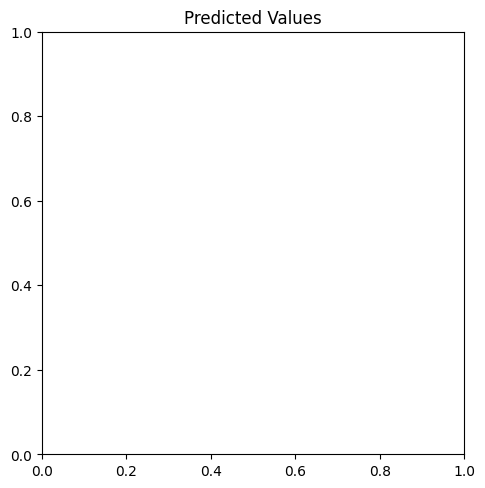

In [11]:
import matplotlib.pyplot as plt

# Load or define actual values for the test data
# actual_values = ...

# Plotting
plt.figure(figsize=(12, 6))

# Actual values
plt.subplot(1, 2, 1)
plt.title("Actual Values")
plt.imshow(actual_values)  # Replace with actual value array
plt.colorbar()

# Predicted values
plt.subplot(1, 2, 2)
plt.title("Predicted Values")
plt.imshow(predictions[0])  # Assuming predictions are in the correct shape
plt.colorbar()

plt.show()


file matching

In [ ]:
import os
from osgeo import gdal

def get_raster_shape(file_path):
    dataset = gdal.Open(file_path)
    if dataset is None:
        return None
    return (dataset.RasterYSize, dataset.RasterXSize)

def list_files_in_directory(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.tif')]

def get_shapes_of_tiffs_in_directory(directory):
    files = list_files_in_directory(directory)
    return {file: get_raster_shape(file) for file in files}

# File paths
elevation_file = '/content/x1_Dem.tif'
rainfall_folder = '/content/rain_raster'
soil_moisture_folder = '/content/2016_soil_m'

# Execute the functions
elevation_shape = get_raster_shape(elevation_file)
rainfall_shapes = get_shapes_of_tiffs_in_directory(rainfall_folder)
soil_moisture_shapes = get_shapes_of_tiffs_in_directory(soil_moisture_folder)

# Print the results
print("Elevation Shape:", elevation_shape)
print("Rainfall Shapes:", rainfall_shapes)
print("Soil Moisture Shapes:", soil_moisture_shapes)


mnist test

In [ ]:
import tensorflow as tf
import numpy as np

# Parameters
apply_positional_encoding = True
ndl = 8  # Number of dense layers in MLP
dlw = 256  # Dense layer width

# Positional Encoding function
def positional_encoding(inputs):
    positional_encoding_dims = 6
    image_height_x_image_width, cha = inputs.shape
    inputs_freq = tf.stack([inputs * 2.0 ** i for i in range(positional_encoding_dims)])
    x = tf.concat([tf.sin(inputs_freq), tf.cos(inputs_freq)], axis=-1)
    x = tf.reshape(x, [image_height_x_image_width, -1])
    x = tf.concat([inputs, x], axis=-1)
    return x

# Batch Encoding function
def batch_encoded(inputs):
    img_list = []
    for i in range(inputs.shape[0]):
        c = tf.reshape(inputs[i], [-1, inputs.shape[-1]])
        p = positional_encoding(c)
        img_list.append(tf.reshape(p, [inputs.shape[1], inputs.shape[2], p.shape[-1]]))
    return tf.stack(img_list)

# Convert grayscale MNIST images to artificial color images
def convert_to_color_mnist(grayscale_images):
    return np.repeat(grayscale_images[..., np.newaxis], 3, axis=-1)

# Load the MNIST dataset
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = tf.keras.datasets.mnist.load_data()

# Convert grayscale images to color
color_mnist_train_images = convert_to_color_mnist(mnist_train_images)
color_mnist_test_images = convert_to_color_mnist(mnist_test_images)

# Normalize the color images to the range [0, 1]
color_mnist_train_images = color_mnist_train_images.astype("float32") / 255.0
color_mnist_test_images = color_mnist_test_images.astype("float32") / 255.0

# Create and compile the model for color to grayscale image conversion
def create_model():
    input_layer = tf.keras.layers.Input(shape=(28, 28, 3))

    x = input_layer

    for i in range(ndl):
        x = tf.keras.layers.Dense(dlw, activation='relu')(x)

        # Add residual connection after the 4th dense layer
        if i == 4:
            x = tf.keras.layers.Concatenate()([x, input_layer])  # Residual connection

    output_layer = tf.keras.layers.Dense(1)(x)  # Output is grayscale, so only 1 channel

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Reshape grayscale labels to match the model's output shape
mnist_train_labels = mnist_train_labels.reshape(-1, 1, 1, 1)
mnist_test_labels = mnist_test_labels.reshape(-1, 1, 1, 1)

# Detect TPU and return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()  # Default strategy that works on CPU and single GPU

with strategy.scope():
    model = create_model()

# Train the model on color images and predict grayscale images
model.fit(color_mnist_train_images, mnist_train_labels, epochs=5)
predicted_grayscale_images = model.predict(color_mnist_test_images)


In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a variable predicted_grayscale_images containing the predicted grayscale images

# Plot the first five predicted grayscale images
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(predicted_grayscale_images[i, :, :, 0], cmap='gray')
    plt.title(f"Predicted Image {i + 1}")
    plt.axis('off')

plt.show()


##**setting up the data pipeline**

In [ ]:
import tensorflow as tf
import pathlib
dir='/content/files'
urls = 'https://github.com/1kaiser/Snow-cover-area-estimation/releases/download/v1/imagesfolder.zip'
data_dir = tf.keras.utils.get_file(origin=urls,
                                   fname='s',
                                   cache_subdir= dir,
                                   archive_format='auto',
                                   untar=False,
                                   extract=True)
!rm -r {dir}/s
data_dir = pathlib.Path(data_dir)

GeoTiff to Image & Image to Geotiff conversion


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
import re

from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

def get_gain_band(input_file):
    """get GAIN_BAND from meta file (*.tif.txt)"""
     # define file name of *.tif.txt
    ifile_txt = re.sub(r'.tif', '.tif.txt', input_file)
    ld = open(ifile_txt)
    lines = ld.readlines()
    ld.close()

    gain_band = []
    for line in lines:
        if line.find("GAIN_BAND") >= 0:
             gain_band.append(float((re.split(' ', line)[1]).strip()))
    return gain_band

def tif2array(input_file, calc_gain=True):
    """
    read GeoTiff and convert to numpy.ndarray.
    Inputs:
        input_file (str) : the name of input GeoTiff file.
        calc_gain (bool) : wheter calc GAIN to DN  or not (defaul:True).
    return:
        image(np.array) : image for each bands
        dataset : for gdal's data drive.
    """
    dataset = gdal.Open(input_file, gdal.GA_ReadOnly)
    # Allocate our array using the first band's datatype
    image_datatype = dataset.GetRasterBand(1).DataType
    image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                     dtype=float)

    if calc_gain == True:
        # get gain
        gain = get_gain_band(input_file)

    # Loop over all bands in dataset
    for b in range(dataset.RasterCount):
        # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
        band = dataset.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        if calc_gain == True:
            # calc gain value for each bands
            image[:, :, b] = band.ReadAsArray() * gain[b]
        else:
            image[:, :, b] = band.ReadAsArray()
    return image, dataset

def array2raster(newRasterfn, dataset, array, dtype):
    """
    save GTiff file from numpy.array
    input:
        newRasterfn: save file name
        dataset : original tif file
        array : numpy.array
        dtype: Byte or Float32.
    """
    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform()

    driver = gdal.GetDriverByName('GTiff')

    # set data type to save.
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Byte":
        GDT_dtype = gdal.GDT_Byte
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")

    # set number of band.
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]

    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))

    # # Loop over all bands.
    # for b in range(band_num):
    #     outband = outRaster.GetRasterBand(b + 1)
    #     # Read in the band's data into the third dimension of our array
    #     if band_num == 1:
    #         outband.WriteArray(array)
    #     else:
    #         outband.WriteArray(array[:,:,b])
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array.reshape(rows, cols))
    # setting srs from input tif file.
    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    return newRasterfn

In [ ]:
image_dir = r'/content/files/'

#############################################################################
prefix = "sur_refl_"
end = ["b01", "b02", "b03", "b04", "b05", "b06", "b07", "day_of_year", "qc_500m", "raz", "state_500m", "szen", "vzen"]
DayOY = "_doy\[0-9]+_aid0001"
fileExt = r'.tif'
expression_b1 = prefix+end[0]
expression_b2 = prefix+end[1]
expression_b3 = prefix+end[2]
expression_b4 = prefix+end[3]
expression_b5 = prefix+end[4]
expression_b6 = prefix+end[5]
expression_b7 = prefix+end[6]


imgs_list_b1 = [f for f in os.listdir(image_dir) if f.__contains__(expression_b1)]

imgs_list_b1.sort(reverse=True)                     #<<<< to start file streaming from the last date 2022 >> 2021 >> 2020 ....


In [ ]:
from google.colab import output
temp_dir = r'/content/'
def ybatchedimages(images_path, image_list, batch_idx):
  images = []
  for id in range(len(batch_idx)):
    path = os.path.join(images_path, image_list[id])
    pathb2 = path.replace(expression_b1, expression_b2)
    pathb4 = path.replace(expression_b1, expression_b4)
    pathb6 = path.replace(expression_b1, expression_b6)

    #creating file NDSI
    !gdal_calc.py \
      --overwrite \
      --type=Float32 \
      -A {pathb4} \
      --A_band 1 \
      -B {pathb6} \
      --B_band 1 \
      --outfile={temp_dir}"NDSI_result.tif" \
      --calc="(A.astype(float) - B)/(A.astype(float) + B)"

    !gdal_calc.py \
      --overwrite \
      --type=Float32 \
      --NoDataValue=0 \
      -A {pathb2} \
      --A_band 1 \
      -B {temp_dir}"NDSI_result.tif" \
      --B_band 1 \
      --outfile={temp_dir}"BothCheck_result.tif" \
      --calc="(A.astype(float)/10000>0.11)*(B.astype(float)>=0.4)"#--calc="(A.astype(float)>0.011*A.astype(float))"#

    pathout = temp_dir+str('BothCheck_result.tif')
    images.append(normalize(tif2array(pathout,0)[0]))
    !rm -r {temp_dir}"NDSI_result.tif"
    !rm -r {temp_dir}"BothCheck_result.tif"
    output.clear()
  return images


def normalize(arr):
    ''' Function to normalize an input array to 0-1 '''
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)


import jax.numpy as jnp
def batchedimages(images_path, image_list, batch_idx):
  images = []
  for id in range(len(batch_idx)):
    path = os.path.join(images_path, image_list[id])
    v1 = normalize(tif2array(path.replace(expression_b1, expression_b1),0)[0])
    v2 = jnp.append(v1, normalize(tif2array(path.replace(expression_b1, expression_b2),0)[0]) , axis =2)
    v3 = jnp.append(v2, normalize(tif2array(path.replace(expression_b1, expression_b3),0)[0]) , axis =2)
    v4 = jnp.append(v3, normalize(tif2array(path.replace(expression_b1, expression_b4),0)[0]) , axis =2)
    v5 = jnp.append(v4, normalize(tif2array(path.replace(expression_b1, expression_b5),0)[0]) , axis =2)
    v6 = jnp.append(v5, normalize(tif2array(path.replace(expression_b1, expression_b6),0)[0]) , axis =2)
    v7 = jnp.append(v6, normalize(tif2array(path.replace(expression_b1, expression_b7),0)[0]) , axis =2)
    images.append(v7)
    w1 = tif2array(path.replace(expression_b1, expression_b1),0)[0]
    w2 = tif2array(path.replace(expression_b1, expression_b2),0)[0]
    w3 = tif2array(path.replace(expression_b1, expression_b3),0)[0]
    w4 = tif2array(path.replace(expression_b1, expression_b4),0)[0]
    w5 = tif2array(path.replace(expression_b1, expression_b5),0)[0]
    w6 = tif2array(path.replace(expression_b1, expression_b6),0)[0]
    w7 = tif2array(path.replace(expression_b1, expression_b7),0)[0]
  return images

import jax.random as random
import jax.numpy as jnp
batch_size = 5
no_of_batches = int(len(imgs_list_b1)/batch_size)
def data_stream():
  key = random.PRNGKey(0)
  perm = random.permutation(key, len(imgs_list_b1))
  x_img_list = []
  y_img_list = []
  for i in range(no_of_batches):
    batch_idx = perm[i * batch_size : (i + 1) * batch_size]; #print(batch_idx)
    # x_img_list.append(batchedimages(x_total_images_path, batch_idx))
    # y_img_list.append(batchedimages(y_total_images_path, batch_idx))
    yield jnp.asarray(batchedimages(image_dir, imgs_list_b1, batch_idx)), jnp.asarray(ybatchedimages(image_dir, imgs_list_b1, batch_idx))

## **RUN 2 testing**

**Model and training code**
Our model is a coordinate-based multilayer perceptron. In this example, for each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$ or any $(gray)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

**POSITIONAL ENCODING BLOCK**

In [ ]:
#✅
import jax
import jax.numpy as jnp


positional_encoding_dims = 6  # Number of positional encodings applied

def positional_encoding(args):
    image_height_x_image_width, cha = args.shape
    inputs_freq = jax.vmap(lambda x: args * 2.0 ** x)(jnp.arange(positional_encoding_dims))
    x = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    x = x.swapaxes(0, 2)
    x = x.reshape([image_height_x_image_width, -1])
    x = jnp.concatenate([args, x], axis=-1)
    return x

def batch_encoded(args):
    img_list = []
    for i in range(args.shape[0]):
        c = args[i]
        c = c.reshape(-1, c.shape[2])
        p = positional_encoding(c)
        img_list.append(p.reshape(args.shape[1],args.shape[2],p.shape[1]))
        x = jnp.array(img_list)
    return x



**MLP MODEL DEFINATION**
Basically, passing input points through a simple Fourier Feature Mapping enables an MLP to learn high-frequency functions (such as an RGB image) in low-dimensional problem domains (such as a 2D coordinate of pixels).

In [ ]:
#✅
!python -m pip install -qq -U flax orbax
# Orbax needs to enable asyncio in a Colab environment.
!python -m pip install -qq nest_asyncio


import jax
import jax.numpy as jnp

import flax
import optax
from typing import Any

from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils

apply_positional_encoding = True # Apply posittional encoding to the input or not
ndl = 8 # num_dense_layers Number of dense layers in MLP
dlw = 256 # dense_layer_width Dimentionality of dense layers' output space

##########################################<< MLP MODEL >>#########################################
class MLPModel(nn.Module):
    dtype: Any = jnp.float32
    precision: Any = lax.Precision.DEFAULT
    apply_positional_encoding: bool = apply_positional_encoding
    @nn.compact
    def __call__(self, input_points):
      x = batch_encoded(input_points) if self.apply_positional_encoding else input_points
      for i in range(ndl):
          x = nn.Dense(dlw,dtype=self.dtype,precision=self.precision)(x)
          x = nn.relu(x)
          x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x
      x = nn.Dense(1, dtype=self.dtype, precision=self.precision)(x)
      return x
##########################################<< MLP MODEL >>#########################################

**initialize the module**

In [ ]:
#✅
!python -m pip install -q -U flax
import optax
from flax.training import train_state
import jax.numpy as jnp
import jax


def Create_train_state(r_key, model, shape, learning_rate ) -> train_state.TrainState:
    print(shape)
    variables = model.init(r_key, jnp.ones(shape))
    optimizer = optax.adam(learning_rate)
    return train_state.TrainState.create(
        apply_fn = model.apply,
        tx=optimizer,
        params=variables['params']
    )

learning_rate = 1e-1
model = MLPModel() # Instantiate the Model

**kernel visualization of the model being used**

In [ ]:
def VisualizeKernel(state_parameters, epochs):
  import cv2
  from google.colab.patches import cv2_imshow
  import numpy as np
  params = state_parameters
  a = []
  for i in params:
    kernel = params[str(i)]['kernel']
    a.append(np.array(kernel))

  import numpy as np
  import matplotlib.pyplot as plt

  rangex = len(params.keys())

  fig, axs = plt.subplots(2, int(rangex/2)+1, figsize=(20,20))
  images = [params[str(i)]['kernel'] for i in params]
  for i, ax in enumerate(axs.flatten()):
      if i < len(images):
          ax.imshow(images[i], cmap='ocean')
      else:
          ax.remove()
  plt.savefig(str(epochs)+'.png', dpi=500)
  plt.show()



**defining loss function**

In [ ]:
#serial
def image_difference_loss(logits, labels):
    loss =  0.5 * jnp.mean((logits - labels) ** 2)
    return loss
def compute_metrics(*, logits, labels):
  loss = image_difference_loss(logits, labels)
  metrics = {
      'loss': loss,     #LOSS
      'logits': logits, #PREDICTED IMAGE
      'labels': labels  #ACTUAL IMAGE
  }
  return metrics

**train step defination**

In [ ]:
#cpu serial
import jax

def train_step(state: train_state.TrainState, batch: jnp.asarray, rng):
    image, label = batch
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, image);
        loss =  image_difference_loss(logits, label);
        return loss, logits

    gradient_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = gradient_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    logs = compute_metrics(logits=logits, labels=label)
    return new_state, logs

import jax
@jax.jit
def eval_step(state, image):
    logits = state.apply_fn({'params': state.params}, image)
    return compute_metrics(logits=logits, labels=image)


**image viewing**

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
def show_image(argu):
  L1 = argu[0]
  predicted_image = np.array(argu[0]*255,  dtype=np.uint8).reshape(newsize) # This would be your image array
  a = predicted_image
  for i in range(0,argu.shape[0]):
    predicted_image = np.array(argu[i]*255,  dtype=np.uint8).reshape(newsize)
    a = cv2.hconcat([a, predicted_image])
  cv2_imshow(a)

In [ ]:
#@title # **👠HIGH HEELS RUN >>>>>>>>>>>** { vertical-output: true }
newsize = (233, 454) #(260, 260) # /.... 233 * 454

import jax
from jax import random
from tqdm import tqdm
import re
from google.colab import output
import orbax.checkpoint as orbax
from flax.training import checkpoints

import optax
import nest_asyncio
nest_asyncio.apply()

rng = jax.random.PRNGKey(0)
CKPT_DIR = 'ckpts'

######################<<<< initiating train state
count = 0
if count == 0 :
  batches = data_stream()
  BATCH, H, W, Channels = next(batches)[0].shape
  state = Create_train_state( rng, model, (BATCH, H, W, Channels ), learning_rate )
  count = 1
#✅✅🔻 state = flax.jax_utils.replicate(state)  # FLAX will replicate the state to every device so that updating can be made easy

######################
checkpoint_available = 0
pattern = re.compile("checkpoint_\d+")   # to search for "checkpoint_*munerical value*" numerical value of any length is denoted by regular expression "\d+"
dir = "/content/ckpts/"
isFile = os.path.isdir(dir)
if isFile:
  for filepath in os.listdir(dir):
      if pattern.match(filepath):
          checkpoint_available = 1

total_epochs = 50
batches = data_stream()
for epochs in tqdm(range(no_of_batches-5)):


  if checkpoint_available:
    state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
    checkpoint_available = 0 # << Flag updated >>> to stop loading the same checkpoint in the next iteration then remove the checkpoint directory
    !rm -r {dir}

  input_data = next(batches)

  for bbb in tqdm(range(total_epochs)):
    state, metrics = train_step(state, input_data, rng)
    show_image(metrics['logits'])

    # output.clear()
    print("loss: ",metrics['loss']," <<< ") # naming of the checkpoint is "checkpoint_*"  where "*" => value of the steps variable, i.e. 'epochs'
    if (bbb == total_epochs-1) :
      VisualizeKernel(state.params, epochs)

  orbax_checkpointer = orbax.Checkpointer(orbax.PyTreeCheckpointHandler())
  checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=state, step=epochs, prefix='checkpoint_', keep=1, overwrite=False, orbax_checkpointer=orbax_checkpointer)
  # restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state) # using to get the checkpoint loaded , it can be latest one , or if already available as checkpoint in the "CKPT_DIR" directory then take the file from directory then save in >> restored_checkpoints
  ##################################################



**inference engine**

In [ ]:

# # newsize = (140,140) #(260, 260) # /.... 233 * 454
# from google.colab.patches import cv2_imshow
# import numpy as np
# from google.colab import output

# !wget https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg -O a.jpg
# image_in = '/content/a.jpg'

# from PIL import Image
# import jax.numpy as jnp
# def imageRGB(argv):
#     im = Image.open(argv)
#     tvt, tvu = jnp.asarray(im.resize(newsize)),jnp.asarray(im.resize(newsize)).reshape(-1,3)
#     return tvt, tvu
# image = jnp.asarray((imageRGB(image_in)[1]))
# #restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
# #state = restored_state
# prediction = eval_step(state, image)
# prediction['loss']


# predicted_image = np.array(prediction['logits'],  dtype=np.uint8).reshape(newsize)
# cv2_imshow(predicted_image)
